## Code Setup

Setup.py

In [ ]:
# Instructions to load Health Care dataset, you must place the provided obesity.csv into your main google drive https://drive.google.com/drive/my-drive
# Then you will have to run this first code statement which will link the google drive

from google.colab import drive
drive.mount('/content/gdrive')
# install below if you do not have texttable package
!pip install texttable

from collections import defaultdict
import copy
import datetime
import gc
import itertools
from itertools import combinations
import re
import math
from pprint import pprint
import random
from random import randint
import warnings
from texttable import Texttable
warnings.filterwarnings("ignore", category=UserWarning) 

import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
from scipy.stats import wasserstein_distance
from sklearn.metrics import f1_score
from sklearn import preprocessing
import pandas as pd
import io
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import datasets, transforms
from torchvision import models

# Set seeds
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a dictionary of arguments used throughout the code
args={}

# Data and partitioning args
args['dataset'] = 'MNIST' # MNIST, CIFAR-10, HC
args['k_classes'] = 4 # Number of classes on each client
args['data_qty_var'] = 0.8 # How much the number of samples per client can vary
args['num_clients'] = 30 # Total clients in the network
args['num_samples'] = 500 # Number of samples per client

# Torch related args
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if args['dataset'] == 'MNIST':
    args['lr'] = 0.01
    args['momentum']=0.9
    args['batch_size']= 10
    args['epochs']= 1
    args['optimiser'] = 'SGD'
elif args['dataset'] == 'CIFAR-10':
    args['lr'] = 0.001
    args['momentum']= 0.9
    args['batch_size']= 32
    args['epochs']= 5
    args['optimiser'] = 'SGD'
elif args['dataset'] == 'HC':
    args['lr'] = 0.001
    args['momentum']=0.6
    args['batch_size']= 150
    args['epochs']= 30
    args['optimiser'] = 'SGD'
args['pretrained'] = False

# Federated Learning args
args['aggregator'] = 'FedAvg' # FedAvg, FedProx, FedPer, SCAFFOLD
args['communication_rounds'] = 2
args['selection_type'] = 'random'
args['select_k_devices'] = 20
args['validate'] = True
args['fedprox_mu'] = 0.01
args['fedper_layers'] = 1
args['scaffold_global_lr'] = 1

verbose = False # When true, print more during experiments
plot_chart = True # When true, plot charts during experiments

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


servers.py

In [ ]:
class CentralServer:
    '''
    Contains the global model that communicates with the local models.
    args (dict): Dictionary with arguments
    '''
    def __init__(self, args):      
        
        # SCAFFOLD control variate 
        self.c = None
            
        # Create models on the server.
        if args['dataset'] == "MNIST":
            self.model = MNIST_NN().to(device)
        elif args['dataset'] == 'CIFAR-10':
            self.model = MobileNetV2(10, alpha = 1).to(device)
        elif args['dataset'] == 'HC':
            self.model = HC_MLP().to(device)

        
    def send_to_locals(self, local_server_list, aggregator = None):
        '''
        Send a copy of the global model to all local servers
        local_server_list (list): a list of all LocalServers
        '''
        
        # A list of central parameter
        central_params = copy.deepcopy(dict(self.model.named_parameters()))
        central_params_lst = list(central_params.keys())

        # For each server
        for local_svr in local_server_list:
            with torch.no_grad():
                # Copy the central parameters to the server
                if aggregator == 'FedPer':
                    # Mechanism for FedPer:
                    # Don't update the local models with the last layer(s) of weights e.g. [-2] and bias [-1]
                    if param_name not in central_params_lst[args['fedper_layers']*-2:]:
                        for param_name, params in local_svr.model.named_parameters():
                            params.copy_(central_params[param_name])
                else: 
                    # Other Federated Aggregators:
                    # Simply update the local model with the global model
                    for param_name, params in local_svr.model.named_parameters():
                        params.copy_(central_params[param_name])
    
    def select_random_local_models(self, local_server_list, k):
        '''
        Select k models from the list of LocalServers randomly
        local_server_list (list): a list of all LocalServers
        k (int): Specify the number of models to select
        '''
        if k > args['num_clients']:
            print('Cannot select more clients than there are clients. \nSetting k to num_clients')
            k = args['num_clients']

        # Shuffle the local_server_list, randomly changing the order of the list.
        random.shuffle(local_server_list)

        return local_server_list[:k]
    
    def create_control_variate(self):
        '''
        Create a control variate variable for SCAFFOLD
        '''
        # Copy the architecture of the model
        init_model = self.model.state_dict()
        # Initialise all weights to be 0 for the control variate 
        for layer in init_model:
            all_zeros = torch.full_like(init_model[layer], 0)
            init_model[layer] = all_zeros
        self.c = init_model
        
class LocalServer:
    '''
    Contains the local model, communicates with the global server.
    args (dict): Dictionary with arguments
    '''
    def __init__(self, args):

        # Placeholders for DataLoaders
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        
        # SCAFFOLD control variate and deltas
        self.c = None
        self.delta_c_i = None
        self.delta_y_i = None
        
        # Create a model on the server.
        if args['dataset'] == "MNIST":
            self.model = MNIST_NN().to(device)
        elif args['dataset'] == 'CIFAR-10':
            self.model = MobileNetV2(10, alpha = 1).to(device) #10 classes is hardcoded.
        elif args['dataset'] == 'HC':
            self.model = HC_MLP().to(device)

        # Torch related objects on the local server.
        if args['optimiser'] == "SGD":
            self.optimiser = optim.SGD(self.model.parameters()
                                       , lr=args['lr']
                                       , momentum=args['momentum']) 

    def train_local(self, global_svr = None, aggregator = 'FedAvg'):
        '''
        Train a model locally
        '''
        # Start tracking total local training time.
        start_time = datetime.datetime.now()

        for epoch in range(1, args['epochs']+1):

            e_start_time = datetime.datetime.now()
            self.model.train()
            train_loss = 0

            for batch_idx, (data, target) in enumerate(self.train_loader):
                x, y = data.to(device), target.to(device)
                self.model.zero_grad()
                y_hat = self.model(x)
                loss = F.cross_entropy(y_hat, y)

                if aggregator == 'FedProx':
                    # Calculate the proximal term in FedProx.
                    regularisation  = 0.0
                    for layer in self.model.state_dict():
                        regularisation += (args['fedprox_mu'] / 2) \
                                            * torch.norm((self.model.state_dict()[layer] \
                                            - global_svr.model.state_dict()[layer]).float())**2
                    loss += regularisation

                loss.backward()
                self.optimiser.step()

                if aggregator == 'SCAFFOLD':
                    with torch.no_grad():
                        # Calculate line 10 of SCAFFOLD algorithm on client:
                        for param_name, local_param in self.model.named_parameters():
                            new_local_param = local_param \
                                            - (args['lr'] \
                                            * (global_svr.c[param_name] - self.c[param_name]) )

                train_loss += loss.item()

            if aggregator == 'SCAFFOLD':             
                # Initialise c_plus_i and delta_c_i
                # Opportunity to improve code and memory issues: do not use deepcopy.
                c_plus_i = copy.deepcopy(self.c)
                delta_c_i = copy.deepcopy(self.c)

                # Make the calculation of line 12 (i) of SCAFFOLD algorithm:
                for layer in c_plus_i:
                    c_plus_i[layer] = self.c[layer] - global_svr.c[layer] \
                                + ( (global_svr.model.state_dict()[layer] - self.model.state_dict()[layer]) \
                                /(args['epochs'] * args['lr']) )
                    delta_c_i[layer] = c_plus_i[layer] - self.c[layer]
                
                # Update self
                self.c = c_plus_i
                self.delta_c_i = delta_c_i
                
                # Calculate delta_y_i (line 13 of SCAFFOLD algorithm)
                self.delta_y_i = copy.deepcopy(self.model.state_dict())
                for layer in self.model.state_dict():
                    self.delta_y_i[layer] = self.model.state_dict()[layer] \
                                        - global_svr.model.state_dict()[layer]

            e_end_time = datetime.datetime.now()
            
            if args['validate']:
                # Same as train, but without updating the SCAFFOLD control variates.
                self.model.eval()
                val_loss = 0
                true_y = []
                pred_y = []

                for batch_idx, (data, target) in enumerate(self.val_loader):
                    x, y = data.to(device), target.to(device)
                    self.model.zero_grad()
                    y_hat = self.model(x)
                    loss = F.cross_entropy(y_hat, y)
                    
                    if aggregator == 'FedProx':
                        regularisation  = 0.0
                        for layer in self.model.state_dict():
                            #.float() used here to avoid type errors.
                            regularisation += (args['fedprox_mu'] / 2) \
                                                * torch.norm((self.model.state_dict()[layer] \
                                                - global_svr.model.state_dict()[layer]).float())**2 
                        loss += regularisation
                        
                    val_loss += loss.item()
                    true_y += y.cpu().detach().numpy().tolist()
                    pred_y += np.argmax(y_hat.cpu().detach().numpy(), axis = 1).tolist()
                f1 = f1_score(true_y, pred_y, average = 'weighted')

        # Finish tracking total local training time.
        end_time = datetime.datetime.now()
        
        if verbose:
            print("Local client training time: %.2f seconds" % (end_time - start_time).total_seconds())

    def test_local(self, global_svr = None, aggregator = 'FedAvg'):
        '''
        Test a model locally.
        '''
        start_time = datetime.datetime.now()
        
        self.model.eval()
        test_loss = 0
        true_y = []
        pred_y = []

        for batch_idx, (data, target) in enumerate(self.test_loader):   
            x, y = data.to(device), target.to(device)
            self.model.zero_grad()
            y_hat = self.model(x)
            loss = F.cross_entropy(y_hat, y)
            if aggregator == 'FedProx':
                regularisation  = 0.0
                for layer in self.model.state_dict():
                    regularisation += (args['fedprox_mu'] / 2) \
                                        * torch.norm((self.model.state_dict()[layer] \
                                        - global_svr.model.state_dict()[layer]).float())**2
                loss += regularisation
            test_loss += loss.item()
            true_y += y.cpu().detach().numpy().tolist()
            pred_y += np.argmax(y_hat.cpu().detach().numpy(), axis = 1).tolist()
            f1 = f1_score(true_y, pred_y, average = 'weighted')

        # Finish tracking total local testing time.
        end_time = datetime.datetime.now()
        
        return f1, test_loss
    
    def create_control_variate(self):
        '''
        Create a control variate variable for SCAFFOLD
        '''
        init_model = self.model.state_dict()
        for layer in init_model:
            all_zeros = torch.full_like(init_model[layer], 0)
            init_model[layer] = all_zeros
        self.c = init_model

models.py

In [ ]:
 class MNIST_NN(nn.Module):
    '''
    Creates a PyTorch MNIST model.
    Code from: https://gist.github.com/kyunghyuncho/50e9b21bfe217912fa9101ec684af504
    '''
    def __init__(self):
        super(MNIST_NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

class BaseBlock(nn.Module):
    '''
    Part of MobileNet for CIFAR-10.
    Code from: https://github.com/tinyalpha/mobileNet-v2_cifar10
    '''
    alpha = 1

    def __init__(self, input_channel, output_channel, t = 6, downsample = False):
        """
            t:  expansion factor, t*input_channel is channel of expansion layer
            alpha:  width multiplier, to get thinner models
            rho:    resolution multiplier, to get reduced representation
        """ 
        super(BaseBlock, self).__init__()
        self.stride = 2 if downsample else 1
        self.downsample = downsample
        self.shortcut = (not downsample) and (input_channel == output_channel) 

        # apply alpha
        input_channel = int(self.alpha * input_channel)
        output_channel = int(self.alpha * output_channel)
        
        # for main path:
        c  = t * input_channel
        # 1x1   point wise conv
        self.conv1 = nn.Conv2d(input_channel, c, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(c)
        # 3x3   depth wise conv
        self.conv2 = nn.Conv2d(c, c, kernel_size = 3, stride = self.stride, padding = 1, groups = c, bias = False)
        self.bn2 = nn.BatchNorm2d(c)
        # 1x1   point wise conv
        self.conv3 = nn.Conv2d(c, output_channel, kernel_size = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channel)
        

    def forward(self, inputs):
        # main path
        x = F.relu6(self.bn1(self.conv1(inputs)), inplace = True)
        x = F.relu6(self.bn2(self.conv2(x)), inplace = True)
        x = self.bn3(self.conv3(x))

        # shortcut path
        x = x + inputs if self.shortcut else x

        return x

class MobileNetV2(nn.Module):
    '''
    Part of MobileNet for CIFAR-10.
    Code from: https://github.com/tinyalpha/mobileNet-v2_cifar10
    '''
    def __init__(self, output_size, alpha = 1):
        super(MobileNetV2, self).__init__()
        self.output_size = output_size

        # first conv layer 
        self.conv0 = nn.Conv2d(3, int(32*alpha), kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn0 = nn.BatchNorm2d(int(32*alpha))

        # build bottlenecks
        BaseBlock.alpha = alpha
        self.bottlenecks = nn.Sequential(
            BaseBlock(32, 16, t = 1, downsample = False),
            BaseBlock(16, 24, downsample = False),
            BaseBlock(24, 24),
            BaseBlock(24, 32, downsample = False),
            BaseBlock(32, 32),
            BaseBlock(32, 32),
            BaseBlock(32, 64, downsample = True),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 96, downsample = False),
            BaseBlock(96, 96),
            BaseBlock(96, 96),
            BaseBlock(96, 160, downsample = True),
            BaseBlock(160, 160),
            BaseBlock(160, 160),
            BaseBlock(160, 320, downsample = False))

        # last conv layers and fc layer
        self.conv1 = nn.Conv2d(int(320*alpha), 1280, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(1280)
        self.fc = nn.Linear(1280, output_size)

        # weights init
        self.weights_init()

    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, inputs):

        # first conv layer
        x = F.relu6(self.bn0(self.conv0(inputs)), inplace = True)
        # assert x.shape[1:] == torch.Size([32, 32, 32])

        # bottlenecks
        x = self.bottlenecks(x)
        # assert x.shape[1:] == torch.Size([320, 8, 8])

        # last conv layer
        x = F.relu6(self.bn1(self.conv1(x)), inplace = True)
        # assert x.shape[1:] == torch.Size([1280,8,8])

        # global pooling and fc (in place of conv 1x1 in paper)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

class HC_MLP(nn.Module):
    '''
    Creates a PyTorch health dataset model.
    '''
    def __init__(self, num_feature=31, num_class=7):
        super(HC_MLP, self).__init__()

        self.layer_1 = nn.Linear(num_feature, 50) 
        self.layer_2 = nn.Linear(50, 20)
        self.layer_out = nn.Linear(20, num_class) 
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(50)
        self.batchnorm2 = nn.BatchNorm1d(20)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = x.squeeze()
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = x.squeeze()
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x.squeeze()

utilities.py

In [ ]:
def create_local_servers(args):
    '''
    Create and return a list of n local servers
    model_class (string): define the type of model
    args (dict): dictionary of arguments
    '''
    n = args['num_clients']
    local_svr_lst = list()
    
    for i in range(n):
        new_server = LocalServer(args = args)
        local_svr_lst.append(new_server)

    return local_svr_lst

def get_data_loaders():
    if args['dataset'] == "MNIST":
        '''
        MNIST & CIFAR-10: Download DataLoaders from Torch datasets.
        HC: Download from GDrive.
        '''
        main_train_loader = datasets.MNIST('../data'
                                        , train=True
                                        , download=True
                                        , transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize( (0.1307,), (0.3081,))]))          
        main_test_loader = datasets.MNIST('../data'
                                        , train=False
                                        , transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
        # Combine train and test, to be split again in our partitioning algorithm.
        comb_dataset = ConcatDataset([main_train_loader, main_test_loader])
        in_datatset = torch.utils.data.DataLoader(comb_dataset)
        
        return in_datatset

    elif args['dataset'] == 'CIFAR-10':
        
        transform_train = transforms.Compose([transforms.RandomCrop(32, 4), transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_test = transforms.Compose([transforms.ToTensor(), 
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


        main_train_loader = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
        main_test_loader = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
        # Combine train and test, to be split again in our partitioning algorithm.
        comb_dataset = ConcatDataset([main_train_loader, main_test_loader])
        in_datatset = torch.utils.data.DataLoader(comb_dataset)
        
        return in_datatset

    # dataloader for health care dataset, extraction for csv
    elif args['dataset'] == 'HC':
        
        health_data_new = pd.read_csv("/content/gdrive/My Drive/obesity.csv")
        df_new = pd.DataFrame(health_data_new)

        class HealthData(Dataset):
            """ health care dataset train data (which will be split into train, val, test) """

            def __init__(self):
                df = pd.read_csv('/content/gdrive/My Drive/obesity.csv')
                df = df.fillna(0)
                self.df = df

                # Grouping variable names
                self.categorical = ["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC","MTRANS"]
                self.target = "Target"

                # One-hot encoding of categorical variables
                self.frame = pd.get_dummies(df, prefix=self.categorical, dtype=float)

                # Save target and predictors
                self.X = self.frame.drop(self.target, axis=1)
                d = preprocessing.normalize(self.X)
                self.X  = pd.DataFrame(d)
                self.X = self.X.astype(np.float32)
                self.y = df[self.target]

            def __getitem__(self, idx):
                if isinstance(idx, torch.Tensor):
                    idx = idx.tolist()
                return [self.X.iloc[idx].values, self.y[idx]]

            def __len__(self):
                return len(self.df)
        
        dataset = HealthData()
        in_dataset = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
        
        return in_dataset

def loader_to_tensors(loader):
    '''
    Turn a DataLoader into a tensor for further manipulation.
    loader (DataLoader): a Pytorch DataLoader
    '''
    x_list = []
    y_list = []

    for batch_idx, (tnsr, trgt) in enumerate(loader):
        x, y = tnsr.to(device), trgt.to(device)
        # Reshape the data from the dataloader so it will fit the PyTorch model's architecture.
        if args['dataset'] == 'MNIST':
            x = x.view(-1,28,28)
            y = y.squeeze()
        elif args['dataset'] == 'CIFAR-10':
            x = x.view(-1,32,32)
            y = y.squeeze()
        elif args['dataset'] == 'HC':
            x = x.view(-1,1,31)
            y = y.squeeze()

        x_list.append(x)
        y_list.append(y)

    # Stack each tensor from the DataLoader into a tensor (like a dataframe).
    x_tensor = torch.stack(x_list,dim=0)
    y_tensor = torch.stack(y_list,dim=0)
    
    x_array = x_tensor.cpu().numpy()
    y_array = y_tensor.cpu().numpy()
    
    return x_array, y_array

def give_local_models_data_loaders(local_server_list, partitioned_tensors_list, train = "train"):
    '''
    Update LocalServer.train_loader from None to a pre-prepared DataLoader from a list.
    local_server_list (list): a list of LocalServers.
    partitioned_tensors_list (list): a list of DataLoaders ready to be assigned to the servers.
    train (str): If "train", training data. Elif "val", validation data. Elif "test", testing data. 
    '''
    # Verify that there is as many DataLoaders to give as there are local servers.
    assert len(local_server_list) == len(partitioned_tensors_list)
    
    # The index i will track both the local server list and data list.
    if train == "train":
        for i in range(0, len(local_server_list)):
            local_server_list[i].train_loader = partitioned_tensors_list[i]
    elif train == "val":
        for i in range(0, len(local_server_list)):
            local_server_list[i].val_loader = partitioned_tensors_list[i]
    elif train == "test":
        for i in range(0, len(local_server_list)):
            local_server_list[i].test_loader = partitioned_tensors_list[i]
    else:
        "Value must be train, val or test"

def get_data():
    '''
    Download data using data loaders, then extract it from the dataloader to a tensor, put it into train and test.
    This is separate so that it can be run once (because downloading data is time consuming).
    ''' 
    dataset = get_data_loaders()
    x_array, y_array = loader_to_tensors(dataset)
    return x_array, y_array

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

def legend_label_sort(text):
  '''
  The solution for using regex to sort a string alphabtically then numerically comes from:
  http://nedbatchelder.com/blog/200712/human_sorting.html
  float regex comes from https://stackoverflow.com/a/12643073/190597
  '''
  experiments_list = text.copy()
  experiments_list.sort(key=natural_keys)
  legend_ordered_index = [text.index(experiment) for experiment in experiments_list]
  return legend_ordered_index

def dict_plot_loop(experiments_looping_dict, data_looping_dict, args):
    '''
    Function to loop through the training argument dictionaries, and extract the args which have multiple values
    This will then be passed to the visualisation label parameters for ease of comparisons during experimentation
    '''
    output= []
    method_name_print = ""

    for key, values in experiments_looping_dict.items():
        if len(values) > 1:
            output.append(key)
    for key, values in data_looping_dict.items():
        if len(values) > 1:
            output.append(key)
    for item in output:
        method_name_print += f"{item}={args[f'{item}']} " 
    return method_name_print

def find_experiment_colour(aggregator_experiments):
  '''
  This function will take in a full set of experiments and allocate specific line colours to each experiment.
  The line colour is based on the experiment aggregator and ensures that each line is coloured based on the aggregator of choice
  Output of this function is a list of colourmap indexes which can then be referenced in a pyplot call.
  '''
  experiment_colour=[]
  output=[]

  # if all aggregators are the same, use a single colourmap for all experiments
  if len(set(aggregator_experiments)) == 1:
    cmap = plt.get_cmap('rainbow')
    experiment_colour = cmap(np.linspace(0, 1, len(aggregator_experiments)))

  # if more than one aggregator present in experiments, use specific colourmaps per aggregator experiment
  else:

    # set dictionary counter for aggregator
    aggregator_counter_dict={"FedAvg":0,
                            "FedProx":0,
                            "FedPer":0,
                            "SCAFFOLD":0
                            }

    # loop through experiment aggregators and find total counter
    for aggregator in aggregator_experiments:
      output.append(aggregator_counter_dict[aggregator])
      aggregator_counter_dict[aggregator] += 1

    # default colourmaps for all four aggregators
    FedAvg_cmap = plt.get_cmap('Blues')
    FedProx_cmap = plt.get_cmap('Greens')
    FedPer_cmap = plt.get_cmap('Reds')
    SCAFFOLD_cmap = plt.get_cmap('Purples')

    # dictionary to store evenly partitioned colourmap values based on aggregator counter from experiments
    experiment_colour_dict={"FedAvg":FedAvg_cmap(np.linspace(0.9, 0.3, aggregator_experiments.count('FedAvg'))),
                            "FedProx":FedProx_cmap(np.linspace(0.9, 0.3, aggregator_experiments.count('FedProx'))),
                            "FedPer":FedPer_cmap(np.linspace(0.9, 0.3, aggregator_experiments.count('FedPer'))),
                            "SCAFFOLD":SCAFFOLD_cmap(np.linspace(0.9, 0.3, aggregator_experiments.count('SCAFFOLD')))
                            }

    # loop through experiments and return the experiment line colour
    for experiment, color_index in enumerate(output):
      current_experiment = aggregator_experiments[experiment] 
      current_colour = experiment_colour_dict[current_experiment][color_index] #number array
      experiment_colour.append(current_colour)

  return experiment_colour


def FL_visual_matrix(f1, comms, methods, experiment_aggregators, lines):
  '''
  This function will plot all experiments in a matrix style subplot. No pair(s) of experiments will ever be repeated. 
  Can change the (lines) parameters to determne the number of experiments you wish to see in each subplot.
  Colour of the lines will always be consistent with the output of FL_visualisation
  '''

  # find all combinations of experiments (without repeats) and save it to a list of lists
  experiment_combos = []
  experiment_num = list(range(len(f1)))
  for unique_combo in combinations(experiment_num, lines):
      experiment_combos.append(list(unique_combo))

  # specify colour map (identical to the FL_visual function) for ease of comparison
  experiment_line_colours = find_experiment_colour(experiment_aggregators)
  plt.figure(figsize=(15, len(experiment_combos)*2))
  plt.rcParams['axes.facecolor'] = 'white'

  # loop through each unique combination of experiments
  unique_experiments = len(experiment_combos)
  for i, experiment_combo in enumerate(experiment_combos): 
      plt.subplot(int(unique_experiments/2),3,i+1)
      a, b, c = [], [], []
      
      # extract their respective f1 score and labels from the output of training
      for index, experiment in enumerate(experiment_combo): 
          a.append(f1[experiment])
          b.append(comms[experiment])
          c.append(methods[experiment])
          
          # plot both experiments against eachother using the same line colour as FL_visual function
          plt.plot(b[index], a[index], label=c[index], color=experiment_line_colours[experiment], lw=1)
          # order the labels using the legend_label_sort function
          handles, labels = plt.gca().get_legend_handles_labels()
          label_sorted_index = legend_label_sort(c)
          handles, labels = zip(*[(handles[i], labels[i]) for i in label_sorted_index])
          plt.legend(handles, labels, loc="best", prop={'size': 9}, frameon=False)

  # plt.suptitle("\nFederated Learning Accuracy Score Matrix", fontsize=20)
  plt.tight_layout()    
  plt.show()
  print()


def FL_visualisation (acc_scores, comm_rounds, algo_label, experiment_aggregators):
    '''
    Overall visualisation function which will plot the FL training F1 scores across all training loops.
    Will dynamically print paramaters with multiple values in the label
    Each experiment will be associated with a specific colour which is based on the aggregator function. 
    '''

    plt.rcParams['axes.facecolor'] = 'white'
    plt.figure(figsize=(10,7))
    plt.title("Federated Learning Accuracy Scores", fontsize=20)
    plt.xlabel("Communication Rounds")
    plt.ylabel("F1 Accuracy")

    # if plotting one experiment on its own, do not colour code.
    if len(acc_scores) == 1:
        plt.plot(comm_rounds[0], acc_scores[0], label=algo_label[0])
        plt.legend(loc="best", frameon=False, prop={'size': 9})  

    else:
        # obtain experiment colour based on the aggregator of choice and its experiment index position
        experiment_line_colours = find_experiment_colour(experiment_aggregators)
        for experiment in range(len(comm_rounds)):
            plt.plot(comm_rounds[experiment], 
                    acc_scores[experiment], 
                    label=algo_label[experiment], 
                    color=experiment_line_colours[experiment],
                    lw=1)

        # order the labels using the legend_label_sort function
        handles, labels = plt.gca().get_legend_handles_labels()
        label_sorted_index = legend_label_sort(methods)
        handles, labels = zip(*[(handles[i], labels[i]) for i in label_sorted_index])
        plt.legend(handles, labels, loc="best", prop={'size': 10}, frameon=False)

    plt.show()
    print()


def FL_results_table(f1, comms, methods, n):
    '''
    This function will output all FL F1 scores in tabular format. 
    Each row is a communication round
    Each column is a particular experiment based on the parameters of interest
    First row will show the best F1 score and its associated communication round.
    n = step size for communication round printing
    '''
    experiments = len(f1)
    comm_rnds = len(comms[0])
    
    # Specify the first row as the paramater values with line breaks
    full_table = [["Commn \nRnd"] + [method.rstrip().replace(" ", "\n\n") for method in methods]]
    
    # calculate the best F1 score in each experiment and output its value and communication round
    best_score = ['BEST SCORE\n[commn rd]'] + [f"{round(max(f1[experiment]),3)} \n[{f1[experiment].index(max(f1[experiment]))+1}]" for experiment in range(experiments)]
    full_table.append(best_score) 
    
    # loop through the experiments from F1 training and add them to the full_table list
    for comm_rnd in range(comm_rnds): 
        if (comm_rnd+1)%n == 0:
            table_row = [comm_rnd+1]
            for experiment in range(experiments):
                table_row.append(f1[experiment][comm_rnd])
            full_table.append(table_row)

    # output the final table
    t = Texttable(max_width=125)
    t.add_rows(full_table)
    print(t.draw())
    print()



data_partition.py

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
from random import randint
import matplotlib.patches as mpatches
import itertools
from collections import defaultdict
import numpy as np
from numpy import arange

def k_label_allocation(k, num_clients, y_array):
 
    '''
    Function which takes in the value of k, number of active devices, and total number of labels
    This function will randomly allocate labels to each device based on k, such that there is no repeating label in each device
    '''
    total_labels = len(set(y_array))
    label_allocation_dict = {}
    
    # loop through all active devices
    for i in range(num_clients):
        device_output = []
        
        # while there are less than k labels assigned to current device
        while len(device_output) < k:
            label = randint(0, total_labels-1)
            
            # check new label is not already assigned to device
            if label not in device_output:
                device_output.append(label)
                
        # write assigned labels to a dictionary. Values must be sorted for ease of visualisation
        label_allocation_dict[i] = sorted(device_output)
        
    return label_allocation_dict

# shuffle all samples in the train dict and only keep the first n
def device_min_value(sample_dist_train, n):
  
    '''
    Function which takes in the label allocation from Step 1 of data partitioning AND the raw data labels
    Based on the number of samples available, the output will allocate data INDEX numbers to each device
    Output is in the form of a dictionary. Key= device number, Value= sample indexes for the device
    '''
    d={}
    for key, value in sample_dist_train.items():
        if len(value) >= n:
            random.shuffle(value)
            d[key] = value[:n]
        else:
            d[key] = value
    return d

def device_sample_partition(label_allocation_dict, max_samples, data):

    data_dict={}
    labels = list(set(data))
    label_allocation = list(label_allocation_dict.values())

    # create empty dictionary with all labels as a key
    for label in labels:
        data_dict[label] = []

    # loop through all data samples and add index to respective data_dict key
    for index, label in enumerate(data):
        data_dict[label].append(index)

    # randomly suffle index values for each dict key
    for label in data_dict:
        random.shuffle(data_dict[label])

    # calculate the number of samples per label based on device allocation
    # store this data in a new dictionary
    sample_per_label = {}
    device_per_label = {}
    device_label_concat = list(itertools.chain.from_iterable(label_allocation))

    for label in data_dict:
        total_label_count = len(data_dict[label]) #total number of samples for current label
        label_sample_count = device_label_concat.count(label) #count of devices which have been assigned this label
        device_per_label[label] = device_label_concat.count(label)

        if label_sample_count != 0: #ignore labels which are not assigned to any device
            sample_per_label[label] = int(total_label_count / label_sample_count)

    # distribute the samples out to each device
    # each label will be proportioned based on the sample_per_label dictionary
    sample_dist = {}
    
    for device_num, device in enumerate(label_allocation):
        sample_dist[device_num] = [] #create empty dictionary key for current device

        for label in device:
            label_sample_count = sample_per_label[label]
            sample_dist[device_num].append(data_dict[label][:label_sample_count])

            # delete the appended samples from the data_dict to avoid double counting
            del data_dict[label][:label_sample_count]

        sample_dist[device_num] = list(itertools.chain.from_iterable(sample_dist[device_num]))
        random.shuffle(sample_dist[device_num]) #shuffle samples for train/test splitting
    
    # split the sample allocation into test/train/val for each device randomly 80:10:10
    sample_dist_train = {}
    sample_dist_test = {}
    sample_dist_val = {}
    
    for key, value in sample_dist.items():
        threshold1 = int(len(sample_dist[key])*0.8) #80% of samples indexes
        threshold2 = int(len(sample_dist[key])*0.9) #90% of sample indexes
        sample_dist_train[key] = sample_dist[key][:threshold1]
        sample_dist_val[key] = sample_dist[key][threshold1:threshold2]
        sample_dist_test[key] = sample_dist[key][threshold2:]
        
    # set a maximum threshold across all devices and remove the excess samples for certain devices
    sample_dist_train = device_min_value(sample_dist_train, max_samples)
    
    # create a dictionary to aggregate total samples per device in train set
    train_sample_per_device={}
    for k,v in sample_dist_train.items():
        train_sample_per_device[k] = len(list(filter(None, v)))
        
    return sample_dist_train, sample_dist_val, sample_dist_test, train_sample_per_device

def k_label_visual(label_allocation_dict, k):
  
    '''
    Function which visualises the sample quantity allocation to each device
    Output is a stacked bar chart, where each vertical bar represents a single device
    and the colours indicate the label quantity count
    '''
    
    label_allocation = list(label_allocation_dict.values())
    devices = len(label_allocation)
    labels = list(set(itertools.chain.from_iterable(label_allocation)))
    
    # specify automatic colourmap based on number of labels
    cmap = plt.get_cmap('Spectral')
    label_col = cmap(np.linspace(0, 1, len(labels)+1))
    
    plt.figure(figsize=(15,7))

    # plot the stacked barchart with a uniform bar length for each label
    for device in range(devices):    
        for additional_label in range(k): 
            plt.bar(device, 1, bottom=additional_label, color= label_col[label_allocation[device][additional_label]])

    # specify a manual legend to account for consistent colour:label mapping
    manual_legend = [mpatches.Patch(color=label_col[item], label=item) for item in labels]
    plt.xticks([])
    plt.legend(handles=manual_legend)
    plt.show()

def device_label_visual(label_allocation_dict, sample_dist, y_train, k):
    
    label_allocation = list(label_allocation_dict.values())
    devices = len(label_allocation)
    labels = list(set(itertools.chain.from_iterable(label_allocation)))

    # specify automatic colourmap based on number of labels for both plots
    cmap = plt.get_cmap('Spectral')
    label_col = cmap(np.linspace(0, 1, len(labels)))
    plt.rcParams['axes.facecolor'] = 'white'
    
    plt.figure(figsize=(15,7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    
    # first plot is the distribution of samples and labels by device
    ax0 = plt.subplot(gs[0])
    
    # begin visualisation by looping through devices and all available labels
    for device_num in range(len(label_allocation)):
        
        # specify list for label quantity count in current device
        device_label_count = []
        
        # extract all allocated sample indexes in current device and look up their respectuive labels
        device_samples = sample_dist[device_num]
        device_labels = y_train[device_samples]
        
        # loop through all available labels in FL network
        for label in labels:
                        
            # count how many times the current label appears in the current device and append results
            label_count = list(device_labels).count(label)
            device_label_count.append(label_count)
            #print(device_label_count)

        # plot bar for current device
        bar_running_total = [0]
        for index, bar in enumerate(device_label_count):
            
            # plot the bar for current device and label count
            ax0.bar(device_num, bar, bottom=sum(bar_running_total), color= label_col[index])
            
            # add current label count to a running total to anchor the starting position of the next bar
            bar_running_total.append(bar)

    manual_legend = [mpatches.Patch(color=label_col[index], label=item) for index, item in enumerate(labels)]
    ax0.legend(handles=manual_legend)
    ax0.set_title("Labels and data quantity distribution by device")
    ax0.set_xlabel("\nDevice", fontsize=10)
    ax0.set_ylabel("No. of Samples", fontsize=10)
    ax0.set_xticks([])
    
    # second plot is of the sample quantity distribution by label across all devices
    ax1 = plt.subplot(gs[1])
    
    # obtain all sample indexes across all devices into one list
    output=[]
    for key, values in sample_dist.items():
        output.append(values)

    # convert sample indexes to label names
    all_sample_indexes = list(itertools.chain.from_iterable(output))
    all_sample_labels = y_train[all_sample_indexes]

    # create a new dictionary for the count of values for each label and plot the bar chart iteratively
    samples_per_label = {}
    for index, label in enumerate(labels):
        samples_per_label[label] = (all_sample_labels==label).sum()
        ax1.bar(str(label), samples_per_label[label], color=label_col[index])
    
    ax1.set_title("Distribution by label")
    ax1.set_xlabel("Label", fontsize=10)
    ax1.set_ylabel("No. of Samples", fontsize=10)
    
    plt.suptitle(f'k={k} over {devices} devices', fontsize=15, fontweight='bold')
    plt.show()    

# check devices under threshold
def devices_under_thres_dict(threshold, sample_per_device):
  
    '''
    Functions to determine devices whose sample count fall below a specified threshold and then 'tops up' with replacement.
    The degree of top up can be controlled
    Output is a dictionary with each device as the key and the list of sample indexes as the values.
    '''
    devices_under_thres = {}
  
    for key, values in sample_per_device.items():
        if values < threshold:
            devices_under_thres[key] = threshold - sample_per_device[key]
    return devices_under_thres

#topup devices to meet the threshold
#check the labels in each client and topup from the shuffled main dataset according to the labels in each dataset 
def get_topup_dict(sample_dist_train, devices_under_thres, label_allocation_dict, y_array):
    
    unique_labels = []
    prep_topup    = {}
    topup_dict    = {}
    sel_topup     = {}

    for key in devices_under_thres.keys():
        for lbl in (label_allocation_dict[key]):
            if (lbl not in unique_labels):
                unique_labels.append(lbl)

    values = sample_dist_train.values()
    label_index_list = list(values)

    for k in unique_labels:
        idx = []
        for i in range(0, len(label_index_list)):
            for j in label_index_list[i]:
                if y_array[j] == k:
                    idx.append(j)
        prep_topup[k] = idx

    for keys in devices_under_thres:
        labels = []
        for lbl in label_allocation_dict[keys]:
            labels.extend(prep_topup[lbl])
            topup_dict[keys] = labels
  
    for key, values in topup_dict.items():
        list_values = values
        random.shuffle(list_values)
        sel = devices_under_thres[key]
        sel_topup[key] = list_values[:sel]
    return sel_topup

def merge_sample_dict(sample_dist_train, sel_topup):
    upd_sample_dist = defaultdict(list)
    upd_sample_per_device ={}

    for key in set().union(sample_dist_train, sel_topup):
        for dic in [sample_dist_train, sel_topup]:
            if key in dic:
                upd_sample_dist[key] += dic[key]

    for k,v in upd_sample_dist.items():
        upd_sample_per_device[k] = len(list(filter(None, v)))


    return upd_sample_dist, upd_sample_per_device

def data_quantity_partition(upd_sample_dist, var):
  
    '''
    Function to perform data quantity distribution based on a degree of skewness
    Function will take in high, medium, or low skewness and partition the data quentity to each device accordingly
    Output is a dictionary with the device as keys and the sample indexes as values
    '''
 
    start_range = var
    end_range = 1
    skip = 0.01

    # uncomment this section once we know the respective categories

    #     if var == 'high_var':
    #         start_range = 0.65

    #     elif var == 'med_var':
    #         start_range = 0.85

    #     elif var == 'low_var':
    #         start_range = 0.9

    var_upd_sample_dist = {}
    for key, value in upd_sample_dist.items():
        if start_range < 1:
            perc_data = round(random.choice(list(np.arange(start_range, end_range, skip))),2)
            tempValue = value
            random.shuffle(tempValue)
            cutoff = int(len(tempValue)*perc_data)
            var_upd_sample_dist[key] = tempValue[:cutoff]
            
        else:
            var_upd_sample_dist[key] = value
        
    var_upd_sample_per_device = {key: len(value) for key, value in var_upd_sample_dist.items()}

    return var_upd_sample_dist, var_upd_sample_per_device

def data_partitioning_master(k, var, num_clients, max_samples, y_array, plot_chart = True):
  
    '''
    Master function for all data partitioning functions
    Inputs to this function are as follows:
    k = number of labels per device
    var = degree of data quantity partitioning (high, med, low)
    devices = number of active devices
    y_train = array of ordered data labels
    plot_chart = plot final visualisation, True or False
    Output is the final dictionary of sample distribution per device and the allocation visualisation
    '''

    # run label distribution functions (Step 1)
    label_allocation_dict = k_label_allocation(k, num_clients, y_array)

    # run data partitioning and split into test/train/val (Step 2.1)
    sample_dist_train, sample_dist_val, sample_dist_test, train_sample_per_device = device_sample_partition(label_allocation_dict, max_samples, y_array)
    # Sample each device with replacement (Step 2.2)
    devices_under_thres = devices_under_thres_dict(max_samples, train_sample_per_device)
    sel_topup = get_topup_dict(sample_dist_train, devices_under_thres, label_allocation_dict, y_array)
    upd_sample_dist, upd_sample_per_device = merge_sample_dict(sample_dist_train, sel_topup)

    # run data quantity partitioning (Step 3)
    var_upd_sample_dist, var_upd_sample_per_device = data_quantity_partition(upd_sample_dist, var)

    #visualise the result
    while plot_chart == True:
        device_label_visual(label_allocation_dict, var_upd_sample_dist, y_array, k)
        break

    return var_upd_sample_dist, sample_dist_val, sample_dist_test

def conv_dict_to_tensors(input_dict, x, y, train):

    sample_list = []
    label_list  = []
    data_list   = []
    x_data_list = []
    y_labels_list = []
    partitioned_tensors_list = []

    for key, value in input_dict.items():
        sample_list.append(input_dict[key])

    for sample in sample_list:
        data_list.append(x[sample])
        label_list.append(y[sample])

    for label in label_list:
        y_tensor_labels = torch.from_numpy(label)
        y_labels_list.append(y_tensor_labels)

    for data in data_list:
        x_tensor_data = torch.from_numpy(data)
        x_data_list.append(x_tensor_data)

    for i in range(len(x_data_list)):
        x_with_y_tensor = TensorDataset(x_data_list[i], y_labels_list[i])

        if train == "train":
            loader = DataLoader(x_with_y_tensor
                                    , batch_size = args['batch_size']
                                    , shuffle = False)
        elif train == "val":
            loader = DataLoader(x_with_y_tensor
                                    , batch_size = args['batch_size']
                                    , shuffle = False)
        elif train == "test":
            loader = DataLoader(x_with_y_tensor
                                    , batch_size = args['batch_size']
                                    , shuffle = False)
        else:
            print("Value must be train, val or test")

        partitioned_tensors_list.append(loader)  

    return partitioned_tensors_list

def calculate_EMD (num_clients, train_list, k_classes, max_samples, var):
  
    '''
    Calculation function for EMD
    Inputs to this function are as follows:
    num_clients = number of client/local models (args['num_clients'])
    tran_list = the train dataloader list where the distributed labels are saved (train_DataLoaders_list)
    k_classes = number of classes distributed (args['k_classes'])
    max_samples = max number of samples specified in each local models (args['num_samples'])
    var = sample quantity variance (args['data_qty_var'])
    Output is the average EMD from comparing the local models with each other
    '''

    targets_from_loader = []
    targets_list = []
    merged_targets_list = []
    score_list = []

    for num in range (num_clients):
        targets_from_loader = []
        for data, targets in train_list[num]:
            targets_from_loader += targets.tolist()
        merged_targets_list.append(targets_from_loader)
  
    for a, b in itertools.combinations(merged_targets_list,2):
        label_skewness = wasserstein_distance(a, b)   
        score_list.append(label_skewness)
    avg_emd = sum(score_list) / len(score_list)
  
    print ("Average EMD score from distributing %s labels to %s local models with max sample=%d and %s quantity variance: %.4f" % (k_classes, num_clients, max_samples, var, avg_emd))
  
    return avg_emd

federated_aggregators.py

In [ ]:
def FedAvg(global_svr, local_svrs):
    '''
    Implementation of FedAvg.
    global_svr (class): The global server with the global model
    local_svrs (list): A list of LocalServers which contain local models
    '''    
    avg_f1_scores= []
    communication_round_vis = []
    
    for communication_round in range(1,args['communication_rounds']+1):
        print('\nCommunication round', communication_round)
        start_time = datetime.datetime.now()

        if args['selection_type'] == 'random':
            # Select k random servers
            selected_svrs = global_svr.select_random_local_models(local_server_list = local_svrs, k = args['select_k_devices'])
        else:
            # Select all servers by default.
            selected_svrs = local_svrs
        
        for i in range(0,len(selected_svrs)):
            selected_svrs[i].train_local()

        with torch.no_grad():
            # For each layer of the network, access the global model weights with global_param
            for param_name, global_param in global_svr.model.named_parameters():
                layer_list = []
                # For each server, build up the average layer
                for local_svr in selected_svrs:
                    local_params = copy.deepcopy(dict(local_svr.model.named_parameters()))
                    layer_list.append(torch.tensor(local_params[param_name]))
                avg_layer = nn.parameter.Parameter(torch.stack(layer_list, dim = 0).mean(dim=0))
                global_param.copy_(avg_layer)
        
        # Update the local servers
        global_svr.send_to_locals(local_svrs)

        # Test the models on the selected servers.
        f1_score_results = []
        test_loss_results = []

        for i in range(0,len(selected_svrs)):
            f1, test_loss = selected_svrs[i].test_local()
            f1_score_results.append(f1)
            test_loss_results.append(test_loss)

        avg_f1_score = sum(f1_score_results) / len(selected_svrs)
        avg_loss_score = sum(test_loss_results) / len(selected_svrs)

        end_time = datetime.datetime.now()
        comm_round_time = (end_time - start_time).total_seconds()

        print("Average F1 Score: %.2f" % avg_f1_score, "Average Loss: %.2f" % avg_loss_score, "Comm rd time: %.2f seconds" % comm_round_time)

        # Append this communication round's avg_f1_score, f1_score_results for visualisation
        avg_f1_scores.append(avg_f1_score)
        communication_round_vis.append(communication_round)
        method_name = "FedAvg"

    return avg_f1_scores, communication_round_vis, method_name

def FedProx(global_svr, local_svrs):
    
    avg_f1_scores= []
    communication_round_vis = []
    
    for communication_round in range(1,args['communication_rounds']+1):
        print('\nCommunication round', communication_round)
        start_time = datetime.datetime.now()

        if args['selection_type'] == 'random':
            # Select k random servers
            selected_svrs = global_svr.select_random_local_models(local_server_list = local_svrs, k = args['select_k_devices'])
        else:
            # Select all servers by default.
            selected_svrs = local_svrs
        
        for i in range(0,len(selected_svrs)):
            selected_svrs[i].train_local(global_svr = global_svr, aggregator = 'FedProx')

        with torch.no_grad():
            # For each layer of the network, access the global model weights with global_param
            for param_name, global_param in global_svr.model.named_parameters():
                layer_list = []
                # For each server, build up the average layer
                for local_svr in selected_svrs:
                    local_params = copy.deepcopy(dict(local_svr.model.named_parameters()))
                    layer_list.append(torch.tensor(local_params[param_name]))
                avg_layer = nn.parameter.Parameter(torch.stack(layer_list, dim = 0).mean(dim=0))
                global_param.copy_(avg_layer)
        
        # Update the local servers
        global_svr.send_to_locals(local_svrs)

        # Test the models on the selected servers.
        f1_score_results = []
        test_loss_results = []

        for i in range(0,len(selected_svrs)):
            f1, test_loss = selected_svrs[i].test_local()
            f1_score_results.append(f1)
            test_loss_results.append(test_loss)

        avg_f1_score = sum(f1_score_results) / len(selected_svrs)
        avg_loss_score = sum(test_loss_results) / len(selected_svrs)

        end_time = datetime.datetime.now()
        comm_round_time = (end_time - start_time).total_seconds()

        print("Average F1 Score: %.2f" % avg_f1_score, "Average Loss: %.2f" % avg_loss_score, "Comm rd time: %.2f seconds" % comm_round_time)
        
        # Append this communication round's avg_f1_score, f1_score_results for visualisation
        avg_f1_scores.append(avg_f1_score)
        communication_round_vis.append(communication_round)
        method_name = "FedProx"

    return avg_f1_scores, communication_round_vis, method_name

def FedPer(global_svr, local_svrs):
    
    avg_f1_scores= []
    communication_round_vis = []
    
    for communication_round in range(1,args['communication_rounds']+1):
        print('\nCommunication round', communication_round)
        start_time = datetime.datetime.now()

        if args['selection_type'] == 'random':
            # Select k random servers
            selected_svrs = global_svr.select_random_local_models(local_server_list = local_svrs, k = args['select_k_devices'])
        else:
            # Select all servers by default.
            selected_svrs = local_svrs
        
        for i in range(0,len(selected_svrs)):
            selected_svrs[i].train_local()

        with torch.no_grad():
            central_params_lst = list(global_svr.model.state_dict().keys())
            # For each layer of the network
            for param_name, global_param in global_svr.model.named_parameters():
                # Stop running the loop in the final layer ([-2] final weights, [-1] final bias)
                if param_name not in central_params_lst[args['fedper_layers']*-2:]:
                    layer_list = []
                    # For each server, build up the average layer
                    for local_svr in selected_svrs:
                        local_params = copy.deepcopy(dict(local_svr.model.named_parameters()))
                        layer_list.append(torch.tensor(local_params[param_name]))
                    avg_layer = nn.parameter.Parameter(torch.stack(layer_list, dim = 0).mean(dim=0))
                    global_param.copy_(avg_layer)
        
        # Update the local servers
        global_svr.send_to_locals(local_svrs)

        # Test the models on the selected servers.
        f1_score_results = []
        test_loss_results = []

        for i in range(0,len(selected_svrs)):
            f1, test_loss = selected_svrs[i].test_local()
            f1_score_results.append(f1)
            test_loss_results.append(test_loss)

        avg_f1_score = sum(f1_score_results) / len(selected_svrs)
        avg_loss_score = sum(test_loss_results) / len(selected_svrs)

        end_time = datetime.datetime.now()
        comm_round_time = (end_time - start_time).total_seconds()

        print("Average F1 Score: %.2f" % avg_f1_score, "Average Loss: %.2f" % avg_loss_score, "Comm rd time: %.2f seconds" % comm_round_time)
        
        # Append this communication round's avg_f1_score, f1_score_results for visualisation
        avg_f1_scores.append(avg_f1_score)
        communication_round_vis.append(communication_round)
        method_name = "FedPer"

    return avg_f1_scores, communication_round_vis, method_name


def SCAFFOLD(global_svr, local_svrs):
    '''
    Implementation of SCAFFOLD
    global_svr (class): The global server with the global model
    local_svrs (list): A list of LocalServers which contain local models
    '''    
    avg_f1_scores= []
    communication_round_vis = []
    
    # Initialise the control variates
    global_svr.create_control_variate()
    for local_svr in local_svrs:
        local_svr.create_control_variate()
    
    for communication_round in range(1,args['communication_rounds']+1):
        print('\nCommunication round', communication_round)
        start_time = datetime.datetime.now()

        if args['selection_type'] == 'random':
            # Select k random servers
            selected_svrs = global_svr.select_random_local_models(local_server_list = local_svrs, k = args['select_k_devices'])
        else:
            # Select all servers by default.
            selected_svrs = local_svrs
        
        for i in range(0,len(selected_svrs)):
            selected_svrs[i].train_local(global_svr = global_svr, aggregator = 'SCAFFOLD')

        with torch.no_grad():
            # For layer, build up and average delta_x and delta_c
            for param_name, global_param in global_svr.model.named_parameters():
                delta_xs = []
                delta_cs = []
                
                # Calculate delta_x and delta_c from each server
                for local_svr in selected_svrs:
                    delta_xs.append(local_svr.delta_y_i[param_name])
                    delta_cs.append(local_svr.delta_c_i[param_name])
    
                delta_x = nn.parameter.Parameter(torch.stack(delta_xs, dim = 0).mean(dim=0))
                delta_c = torch.stack(delta_cs, dim = 0).mean(dim=0)

                global_update = global_param + args['scaffold_global_lr'] * delta_x
                global_param.copy_(global_update)
                global_svr.c[param_name] = global_svr.c[param_name] \
                                + (len(selected_svrs) / len(local_svrs)) * delta_c
        
        # Update the local servers
        global_svr.send_to_locals(local_svrs)
        global_c = copy.deepcopy(global_svr.c)
        for local_svr in local_svrs:
            local_svr.c = global_c

        # Test the models on the selected servers.
        f1_score_results = []
        test_loss_results = []

        for i in range(0,len(selected_svrs)):
            f1, test_loss = selected_svrs[i].test_local()
            f1_score_results.append(f1)
            test_loss_results.append(test_loss)

        avg_f1_score = sum(f1_score_results) / len(selected_svrs)
        avg_loss_score = sum(test_loss_results) / len(selected_svrs)

        end_time = datetime.datetime.now()
        comm_round_time = (end_time - start_time).total_seconds()

        print("Average F1 Score: %.2f" % avg_f1_score, "Average Loss: %.2f" % avg_loss_score, "Comm rd time: %.2f seconds" % comm_round_time)

        # Append this communication round's avg_f1_score, f1_score_results for visualisation
        avg_f1_scores.append(avg_f1_score)
        communication_round_vis.append(communication_round)
        method_name = "SCAFFOLD"

    return avg_f1_scores, communication_round_vis, method_name

## Experiment Setup

Run Federated Learning (cells from main.py)

In [ ]:
# Get all datasets to store in original format in memory before any sampling/training
datasets_dict = {}
datasets_list = ['MNIST','CIFAR-10','HC']
for d in datasets_list:
    args['dataset'] = d
    x_array, y_array = get_data()
    datasets_dict[d] = (x_array, y_array)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


## Run Experiments

In [ ]:
# Decide what parameters to change in each experiment:
# Single element list parameters stay the same
# Multiple element lists will test every combination.

data_looping_dict = {
    'dataset' : ['HC']
    , 'num_clients' : [30]
    , 'k_classes' : [7]
    , 'data_qty_var' : [0.99]
    , 'num_samples' : [70]
}

experiments_looping_dict = {
    'aggregator' : ['FedAvg']
    , 'communication_rounds' : [200]
    , 'epochs' : [1,5,20]
    , 'select_k_devices' : [6]
    , 'lr' : [0.001]
    , 'momentum' : [0.9]
    , 'batch_size' : [10]
    , 'optimiser' : ['SGD']
    , 'fedprox_mu' : [0.001]
    , 'fedper_layers' : [1]
    , 'scaffold_global_lr' : [1]
    , 'validate' : [False]
    , 'selection_type' : ['random']
}

# Every combination of the parameters in list of dictionaries format
data_setup_params = [dict(zip(data_looping_dict, value)) for value in itertools.product(*data_looping_dict.values())]
fl_experiment_params = [dict(zip(experiments_looping_dict, value)) for value in itertools.product(*experiments_looping_dict.values())]

# The output is deterministic based on above input, so can be run over different sessions e.g.:
# fl_experiment_params = fl_experiment_params[4:8]
print(len(fl_experiment_params), 'experiments to run')

3 experiments to run


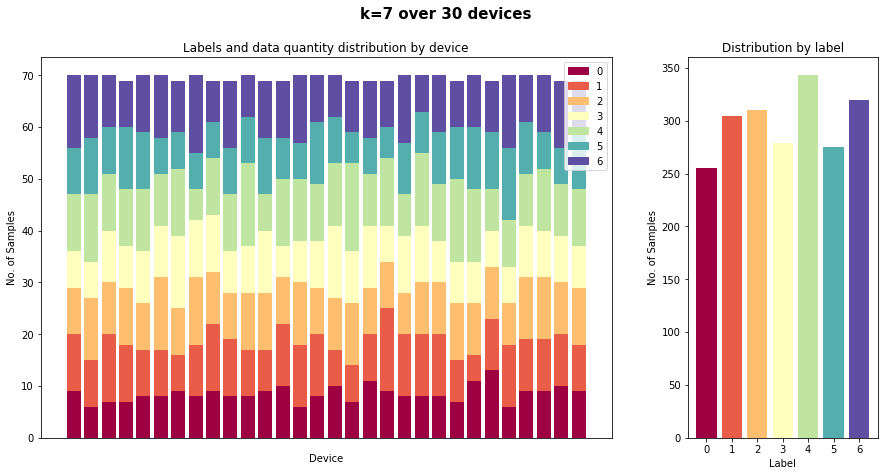

Average EMD score from distributing 7 labels to 30 local models with max sample=70 and 0.99 quantity variance: 0.2277
--------------------------------------------------

Communication round 1
Average F1 Score: 0.03 Average Loss: 1.95 Comm rd time: 0.08 seconds

Communication round 2
Average F1 Score: 0.03 Average Loss: 1.95 Comm rd time: 0.08 seconds

Communication round 3
Average F1 Score: 0.18 Average Loss: 1.94 Comm rd time: 0.08 seconds

Communication round 4
Average F1 Score: 0.05 Average Loss: 1.95 Comm rd time: 0.09 seconds

Communication round 5
Average F1 Score: 0.17 Average Loss: 1.94 Comm rd time: 0.07 seconds

Communication round 6
Average F1 Score: 0.12 Average Loss: 1.94 Comm rd time: 0.09 seconds

Communication round 7
Average F1 Score: 0.06 Average Loss: 1.94 Comm rd time: 0.08 seconds

Communication round 8
Average F1 Score: 0.07 Average Loss: 1.95 Comm rd time: 0.09 seconds

Communication round 9
Average F1 Score: 0.06 Average Loss: 1.93 Comm rd time: 0.09 seconds

Co

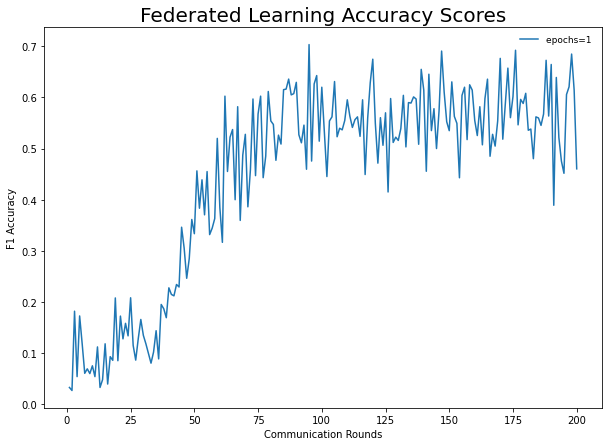



Experiment best F1: 0.7032
Total experiment time: 16.72 seconds

Experiment key:

 dataset:HC|k_classes:7|data_qty_var:0.99|num_clients:30|num_samples:70|lr:0.001|momentum:0.9|batch_size:10|epochs:1|optimiser:SGD|pretrained:False|aggregator:FedAvg|communication_rounds:200|selection_type:random|select_k_devices:6|validate:False|fedprox_mu:0.001|fedper_layers:1|scaffold_global_lr:1

Experiment args:

{'aggregator': 'FedAvg',
 'batch_size': 10,
 'communication_rounds': 200,
 'data_qty_var': 0.99,
 'dataset': 'HC',
 'epochs': 1,
 'fedper_layers': 1,
 'fedprox_mu': 0.001,
 'k_classes': 7,
 'lr': 0.001,
 'momentum': 0.9,
 'num_clients': 30,
 'num_samples': 70,
 'optimiser': 'SGD',
 'pretrained': False,
 'scaffold_global_lr': 1,
 'select_k_devices': 6,
 'selection_type': 'random',
 'validate': False}
--------------------------------------------------

Communication round 1
Average F1 Score: 0.09 Average Loss: 1.95 Comm rd time: 0.31 seconds

Communication round 2
Average F1 Score: 0.05 Aver

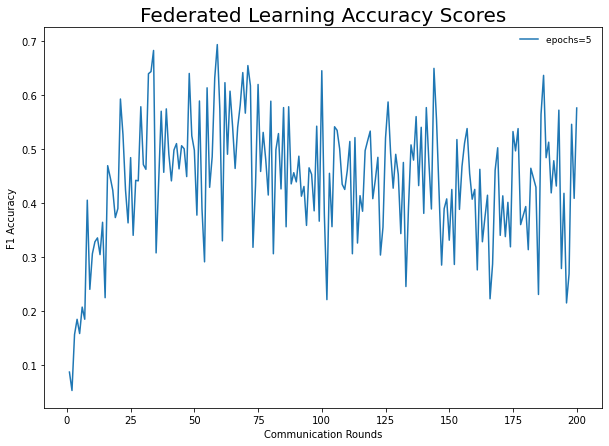



Experiment best F1: 0.6929
Total experiment time: 60.33 seconds

Experiment key:

 dataset:HC|k_classes:7|data_qty_var:0.99|num_clients:30|num_samples:70|lr:0.001|momentum:0.9|batch_size:10|epochs:5|optimiser:SGD|pretrained:False|aggregator:FedAvg|communication_rounds:200|selection_type:random|select_k_devices:6|validate:False|fedprox_mu:0.001|fedper_layers:1|scaffold_global_lr:1

Experiment args:

{'aggregator': 'FedAvg',
 'batch_size': 10,
 'communication_rounds': 200,
 'data_qty_var': 0.99,
 'dataset': 'HC',
 'epochs': 5,
 'fedper_layers': 1,
 'fedprox_mu': 0.001,
 'k_classes': 7,
 'lr': 0.001,
 'momentum': 0.9,
 'num_clients': 30,
 'num_samples': 70,
 'optimiser': 'SGD',
 'pretrained': False,
 'scaffold_global_lr': 1,
 'select_k_devices': 6,
 'selection_type': 'random',
 'validate': False}
--------------------------------------------------

Communication round 1
Average F1 Score: 0.08 Average Loss: 1.97 Comm rd time: 1.15 seconds

Communication round 2
Average F1 Score: 0.23 Aver

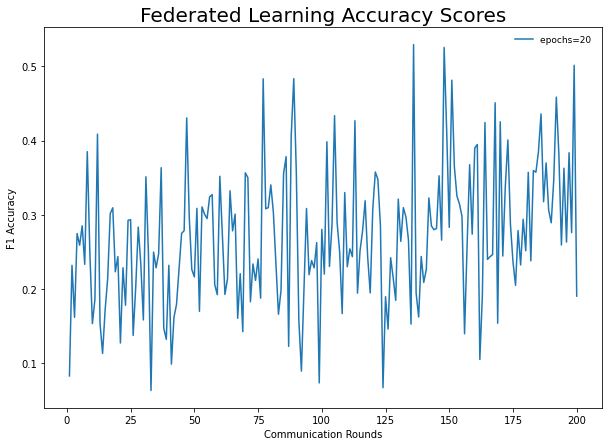



Experiment best F1: 0.5295
Total experiment time: 219.79 seconds

Experiment key:

 dataset:HC|k_classes:7|data_qty_var:0.99|num_clients:30|num_samples:70|lr:0.001|momentum:0.9|batch_size:10|epochs:20|optimiser:SGD|pretrained:False|aggregator:FedAvg|communication_rounds:200|selection_type:random|select_k_devices:6|validate:False|fedprox_mu:0.001|fedper_layers:1|scaffold_global_lr:1

Experiment args:

{'aggregator': 'FedAvg',
 'batch_size': 10,
 'communication_rounds': 200,
 'data_qty_var': 0.99,
 'dataset': 'HC',
 'epochs': 20,
 'fedper_layers': 1,
 'fedprox_mu': 0.001,
 'k_classes': 7,
 'lr': 0.001,
 'momentum': 0.9,
 'num_clients': 30,
 'num_samples': 70,
 'optimiser': 'SGD',
 'pretrained': False,
 'scaffold_global_lr': 1,
 'select_k_devices': 6,
 'selection_type': 'random',
 'validate': False}
----------------------------------------------------------------------------------------------------
Best results from all experiments:

Best overall F1: 0.7032

Best overall model key: 

da

In [ ]:
# Store results in a dictionary and a list with keys of the experiments
results = {}
keys = []
best_f1 = 0
best_f1_key = ''

# For each combination of data setup
for data_setup in data_setup_params:
    for parameter_key in data_setup.keys():
        args[parameter_key] = data_setup[parameter_key]

    # Once data setup is ready for partitioning, get the original data
    x_array, y_array = datasets_dict[args['dataset']]

    # run master data partitioning function to sample original perform train test split
    var_upd_sample_dist, sample_dist_val, sample_dist_test = data_partitioning_master(args['k_classes'],
                                                                                      args['data_qty_var'],
                                                                                      args['num_clients'],
                                                                                      args['num_samples'],
                                                                                      y_array,
                                                                                      plot_chart)

    # Create a list of DataLoaders for LocalServers that will be used for all combinations of experiments
    train_DataLoaders_list = conv_dict_to_tensors(var_upd_sample_dist, x_array, y_array, "train")
    val_DataLoaders_list = conv_dict_to_tensors(sample_dist_val, x_array, y_array, "val")
    test_DataLoaders_list = conv_dict_to_tensors(sample_dist_test, x_array, y_array, "test")

    emd_score = calculate_EMD(args['num_clients'],
                              train_DataLoaders_list,
                              args['k_classes'],
                              args['num_samples'],
                              args['data_qty_var'])

    # For each combination of experiments
    for experiment in fl_experiment_params:
        for parameter_key in experiment.keys():
            args[parameter_key] = experiment[parameter_key]

        start = datetime.datetime.now()
        print('-'*50)

        # Initialise the servers
        central_svr = CentralServer(args)
        local_svrs = create_local_servers(args)
        central_svr.send_to_locals(local_svrs)

        # Give the servers data
        give_local_models_data_loaders(local_svrs, train_DataLoaders_list, train = "train")
        give_local_models_data_loaders(local_svrs, val_DataLoaders_list, train = "val")
        give_local_models_data_loaders(local_svrs, test_DataLoaders_list, train = "test")

        # Federated Learning
        if args['aggregator'] == 'FedAvg':
            avg_f1_scores, communication_round_vis, method_name = FedAvg(central_svr, local_svrs)

        elif args['aggregator'] == 'FedProx':
            avg_f1_scores, communication_round_vis, method_name = FedProx(central_svr, local_svrs)

        elif args['aggregator'] == 'FedPer':
            avg_f1_scores, communication_round_vis, method_name = FedPer(central_svr, local_svrs)

        elif args['aggregator'] == 'SCAFFOLD':
            avg_f1_scores, communication_round_vis, method_name = SCAFFOLD(central_svr, local_svrs)

        # Key is a string of the args used
        key = "|".join( [str(x)+":"+str(y) for x,y in zip(args.keys(), args.values())] )
        keys.append(key)

        # Track the best model
        best_avg_f1 = np.amax(avg_f1_scores)
        if best_avg_f1 > best_f1:
            best_f1 = best_avg_f1
            best_f1_key = key

        # Track how long training took
        end = datetime.datetime.now()
        duration = (end - start).total_seconds()

        # Store the results in a tuple
        # 0: avg_f1_scores
        # 1. communication_round_vis
        # 2. method_name (for charting)
        # 3. best_avg_f1 out of the communication rounds for the current experiment
        # 4. duration
        # 5. args
        # 6. emd_score

        exp_args = copy.deepcopy(args) # For saving experiment args
        method_name_print = dict_plot_loop(experiments_looping_dict, data_looping_dict, exp_args) # For visualisations 
        output = (avg_f1_scores, communication_round_vis, method_name_print, best_avg_f1, duration, exp_args, emd_score)
        results[key] = output

        # Visualise the current experiment
        FL_visualisation([output[0]], [output[1]], [output[2]], exp_args)
        print('\nExperiment best F1: {:.4f}'.format(best_avg_f1))
        print("Total experiment time: %.2f seconds\n" % duration)

        # Print the key and args so they can be accessed more easily
        print('Experiment key:\n\n',key)
        print('\nExperiment args:\n')
        pprint(exp_args)
        
        # Torch memory maintenance.
        del central_svr, local_svrs
        gc.collect()
        torch.cuda.empty_cache()

print('-'*100)
print('Best results from all experiments:\n')
print('Best overall F1: {:.4f}\n\nBest overall model key: \n\n{}\n'.format(best_f1, best_f1_key))
print('\nBest overall model args\n')
pprint(results[best_f1_key][5])
    
experiment_durations = []; print('\n')
for key in keys:
    experiment_durations.append(results[key][4])
    # To access which experiment it actually was: print(results[key][5]) or print(key)
    print('Experiment', keys.index(key), 'time: {:.2f} seconds'.format(results[key][4]))
print('Total experiment time: {:.2f} seconds'.format(sum(experiment_durations)))

In [ ]:
experiments = len(f1)
comm_rnds = len(comms[0])
    
    # Specify the first row as the paramater values with line breaks
full_table = [["Commn \nRnd"] + [method.rstrip().replace(" ", "\n\n") for method in methods]]
    
# calculate the best F1 score in each experiment and output its value and communication round
best_score = ['BEST SCORE\n[commn rd]'] + [f"{round(max(f1[experiment]),3)} \n[{f1[experiment].index(max(f1[experiment]))+1}]" for experiment in range(experiments)]
full_table.append(best_score) 
    
    # loop through the experiments from F1 training and add them to the full_table list
for comm_rnd in range(comm_rnds): 
  if (comm_rnd+1)%1 == 0:
    table_row = [comm_rnd+1]
    for experiment in range(experiments):
      table_row.append(f1[experiment][comm_rnd])
      full_table.append(table_row)

    # output the final table
t = Texttable(max_width=100000)
t.add_rows(full_table)
output = t.draw()

import re
from io import StringIO

# df = pd.read_csv(StringIO(re.sub(r'[-+|]', ' ', str(output))), sep='\s\s+', engine='python')

df = pd.read_csv(StringIO(re.sub(r'[-+|]', ' ', str(output))), sep='\s\s+', engine='python')
df.head()
from google.colab import files
df.to_csv('table_results.csv') 
files.download('table_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

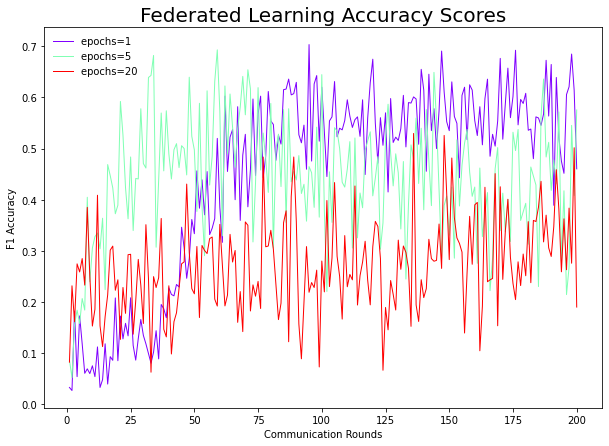

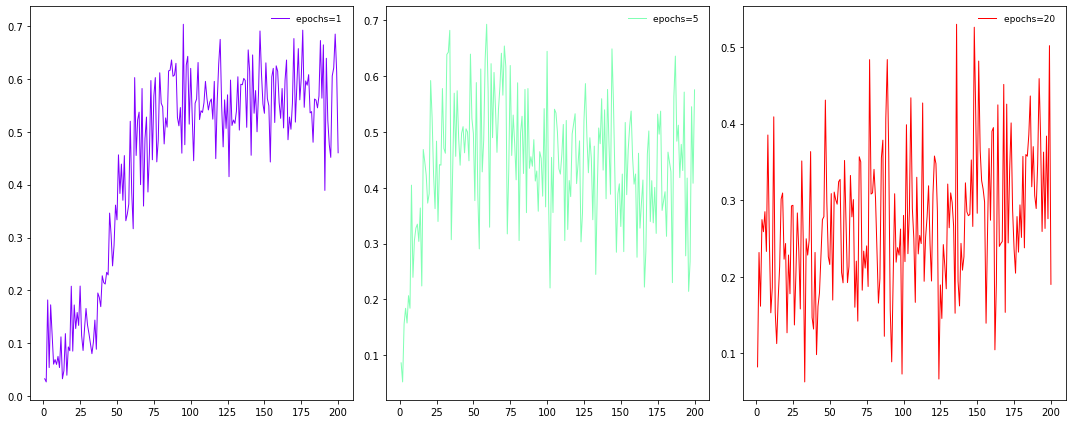


+------------+----------+----------+-----------+
|   Commn    | epochs=1 | epochs=5 | epochs=20 |
|    Rnd     |          |          |           |
+============+==========+==========+===========+
| BEST SCORE | 0.703    | 0.693    | 0.529     |
| [commn rd] | [95]     | [59]     | [136]     |
+------------+----------+----------+-----------+
| 1          | 0.033    | 0.087    | 0.083     |
+------------+----------+----------+-----------+
| 2          | 0.027    | 0.052    | 0.232     |
+------------+----------+----------+-----------+
| 3          | 0.182    | 0.156    | 0.162     |
+------------+----------+----------+-----------+
| 4          | 0.054    | 0.184    | 0.275     |
+------------+----------+----------+-----------+
| 5          | 0.173    | 0.158    | 0.259     |
+------------+----------+----------+-----------+
| 6          | 0.118    | 0.207    | 0.285     |
+------------+----------+----------+-----------+
| 7          | 0.061    | 0.184    | 0.233     |
+------------+-----

In [ ]:
# Unpack the results and chart everything on one chart, output the matrix plot and show results in tabular format

f1 = []
comms = []
methods = []
aggregator_experiments=[]

for key in keys:
    f1.append(results[key][0])
    comms.append(results[key][1])
    methods.append(results[key][2])
    aggregator_experiments.append(results[key][5]['aggregator'])


FL_visualisation(f1, comms, methods, aggregator_experiments)
FL_visual_matrix(f1, comms, methods, aggregator_experiments, 1)
FL_results_table(f1, comms, methods, 1)

In [ ]:
# Print the results to store in text file

for i in results:
    print(i)
    print('\n')
    print(results[i])
    print('\n')